<a href="https://colab.research.google.com/github/lizhieffe/llm_knowledge/blob/main/examples/pytorch_dist/%5BDist%5D_PyTorch_TP_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F

from torch.distributed.tensor.parallel import parallelize_module, ColwiseParallel, RowwiseParallel
from torch.distributed.device_mesh import init_device_mesh

# Simple Row-wise TP

It uses less memory than column-wise TP because row-wise shards the input but the column-wise doesn't shard the input.

Reference
- https://huggingface.co/blog/huseinzol05/tensor-parallelism

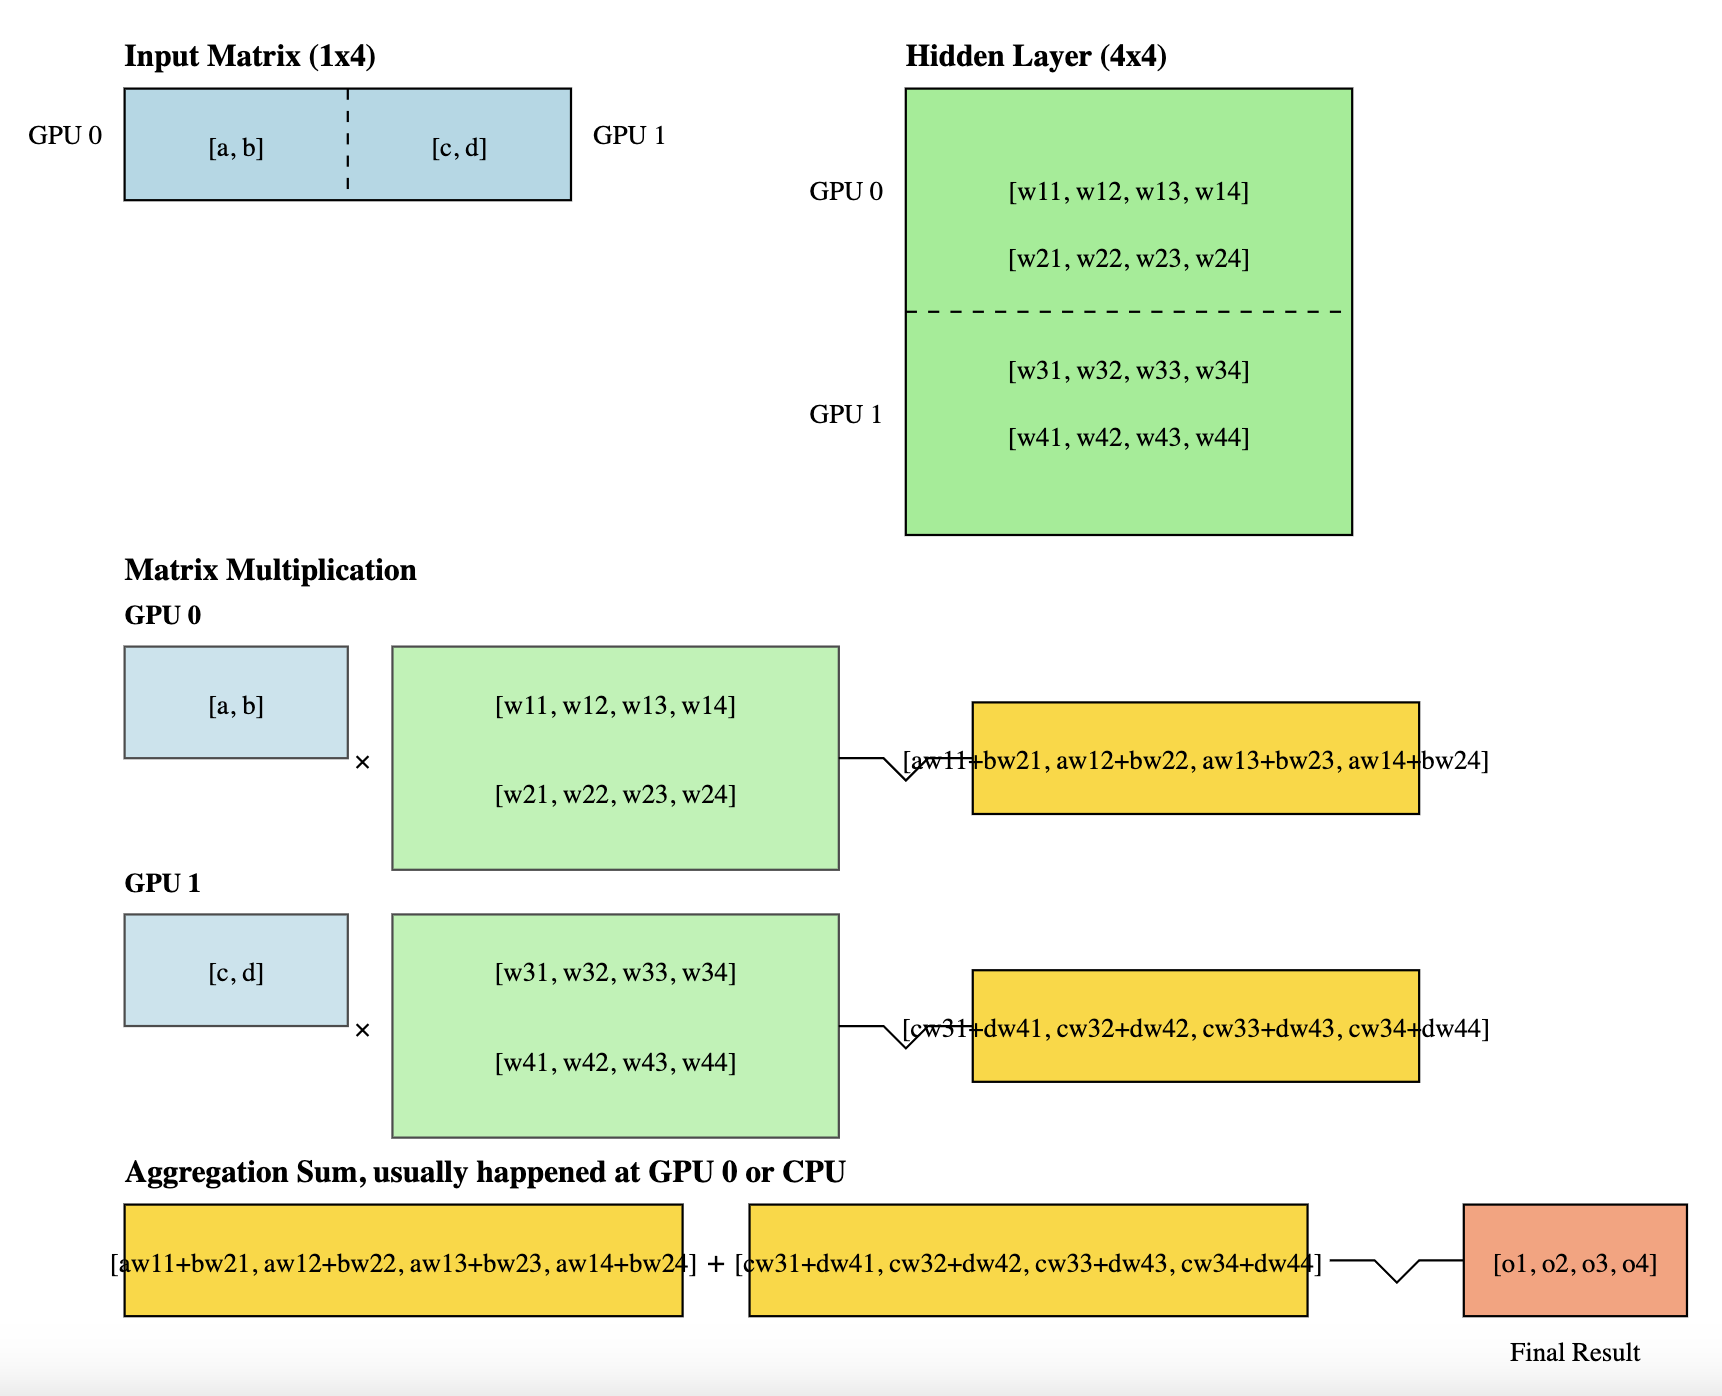

In [2]:
def get_expected_tensor(input: torch.Tensor, weight: torch.Tensor):
  return input @ weight

In [3]:
def init_process_row_wise_tp(rank: int, world_size: int):
  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  # Prepare input
  torch.manual_seed(123)
  input = torch.randn((1, 4))
  assert input.shape == (1, 4)
  assert input.shape[-1] % world_size == 0
  splitted_input_shape = list(input.shape)
  splitted_input_shape[-1] = input.shape[-1] // world_size
  splitted_input = torch.zeros(splitted_input_shape, dtype=torch.float32)

  if rank == 0:
    scatter_list = list(torch.chunk(input, world_size, dim=-1))
  else:
    scatter_list = None
  dist.scatter(splitted_input, scatter_list, src=0)

  # Prepare weight
  weight = torch.randn((4, 4))
  assert weight.shape == (4, 4)

  assert weight.shape[0] % world_size == 0
  splitted_weight_shape = list(weight.shape)
  splitted_weight_shape[0] = splitted_weight_shape[0] // world_size
  splitted_weight = torch.zeros(splitted_weight_shape, dtype=torch.float32)

  if rank == 0:
    scatter_list = list(torch.chunk(weight, world_size, dim=0))
  else:
    scatter_list = None
  dist.scatter(splitted_weight, scatter_list, src=0)

  # Local Matmul
  local_mm = splitted_input @ splitted_weight
  if rank == 0:
    print(f"Before all_reduce: {splitted_input.shape=}, {splitted_weight.shape=}, {local_mm.shape=}")

  # Reduce the result from replicas
  mm = local_mm.clone()
  dist.all_reduce(mm, op=dist.ReduceOp.SUM)
  if rank == 0:
    print(f"After all_reduce: {mm.shape=}")

  # Assert
  assert torch.allclose(get_expected_tensor(input, weight), mm)

  # Finish
  dist.destroy_process_group()

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_row_wise_tp, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()

Starting process with rank=0, world_size=4
Starting process with rank=1, world_size=4Starting process with rank=2, world_size=4

Starting process with rank=3, world_size=4
Before all_reduce: splitted_input.shape=torch.Size([1, 1]), splitted_weight.shape=torch.Size([1, 4]), local_mm.shape=torch.Size([1, 4])
After all_reduce: mm.shape=torch.Size([1, 4])


# Simple Column-wise TP

Reference
- https://huggingface.co/blog/huseinzol05/tensor-parallelism

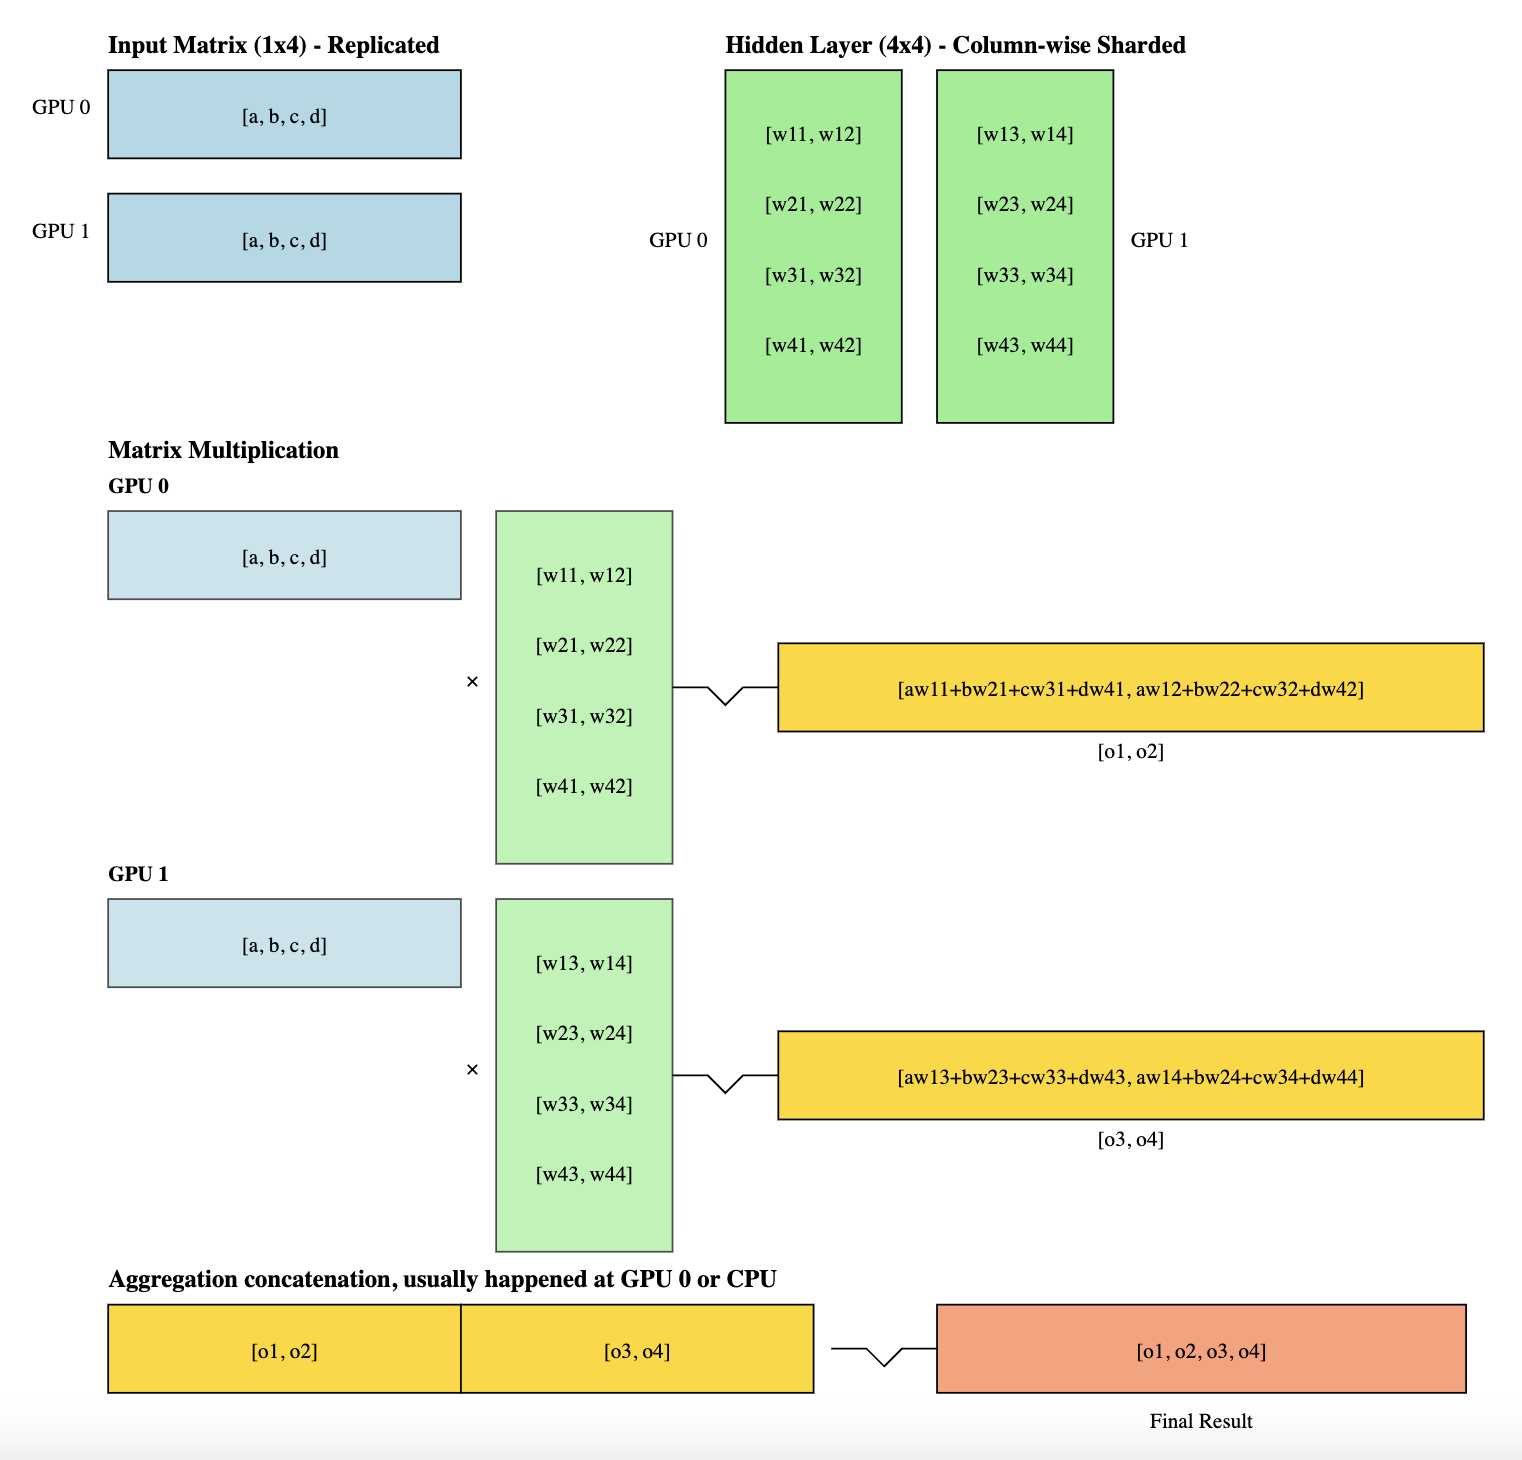

In [4]:
def init_process_column_wise_tp(rank: int, world_size: int):
  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  # Prepare input
  torch.manual_seed(123)
  input = torch.randn((1, 4))
  assert input.shape == (1, 4)

  # Prepare weight
  weight = torch.randn((4, 4))
  assert weight.shape == (4, 4)

  assert weight.shape[1] % world_size == 0
  splitted_weight_shape = list(weight.shape)
  splitted_weight_shape[1] = splitted_weight_shape[1] // world_size
  splitted_weight = torch.zeros(splitted_weight_shape, dtype=torch.float32)

  if rank == 0:
    scatter_list = list(torch.chunk(weight, world_size, dim=1))
    # dist.scatter() assumes the tensor in the scatter_list to be contiguous.
    # https://github.com/pytorch/pytorch/issues/107352
    scatter_list = [it.contiguous() for it in scatter_list]
    assert splitted_weight.shape == scatter_list[0].shape
  else:
    scatter_list = None
  dist.scatter(tensor=splitted_weight, scatter_list=scatter_list, src=0)

  # Local Matmul
  local_mm = input @ splitted_weight
  if rank == 0:
    print(f"Before all_reduce: {input.shape=}, {splitted_weight.shape=}, {local_mm.shape=}")

  # Reduce the result from replicas
  gathered_shape = (input.shape[0], splitted_weight_shape[1])
  gathered = [torch.zeros(gathered_shape, dtype=torch.float32) for _ in range(world_size)]
  dist.all_gather(gathered, local_mm)
  mm = torch.cat(gathered, dim=1)
  if rank == 0:
    print(f"After all_reduce: {mm.shape=}")

  # Assert
  expected = get_expected_tensor(input, weight)
  assert torch.allclose(expected, mm)

  # Finish
  dist.destroy_process_group()

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_column_wise_tp, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()

Starting process with rank=0, world_size=4
Starting process with rank=1, world_size=4
Starting process with rank=2, world_size=4
Starting process with rank=3, world_size=4
Before all_reduce: input.shape=torch.Size([1, 4]), splitted_weight.shape=torch.Size([4, 1]), local_mm.shape=torch.Size([1, 1])
After all_reduce: mm.shape=torch.Size([1, 4])


# Transformer MLP TP with manual sharding

This doesn't use the pytorch lib which shard the weights for you.

https://zhuanlan.zhihu.com/p/366906920

In [5]:
# @title Single device FFN

class PlainFeedForwardNetwork(nn.Module):
  def __init__(self, emb_dim: int):
    super().__init__()

    self.l1 = torch.randn((emb_dim, 4 * emb_dim), dtype=torch.float32)
    # TODO(lizhi): double check is this ReLU
    self.relu = nn.ReLU()
    self.l2 = torch.randn((4 * emb_dim, emb_dim), dtype=torch.float32)

  def forward(self, x: torch.Tensor):
    y = x @ self.l1
    y = self.relu(y)
    y = y @ self.l2
    return y

# Test
torch.manual_seed(123)
input = torch.randn((16, 32)) # [B, EMB]
pffn = PlainFeedForwardNetwork(32)
output = pffn(input)
assert input.shape == output.shape

In [6]:
# @title FFN with TP

class TPFeedForwardNetwork(nn.Module):
  def __init__(self, emb_dim: int, rank: int, world_size: int):
    super().__init__()

    if rank == 0:
      l1 = torch.randn((emb_dim, 4 * emb_dim), dtype=torch.float32)
      l1_scattered_list = torch.chunk(l1, world_size, dim=1)
      l1_scattered_list = [it.contiguous() for it in l1_scattered_list]
      assert len(l1_scattered_list) == world_size
    else:
      l1_scattered_list = None

    l1_shard_shape = (emb_dim, 4 * emb_dim // world_size)
    self.l1_shard = torch.zeros(l1_shard_shape, dtype=torch.float32)
    dist.scatter(self.l1_shard, l1_scattered_list, src=0)

    # TODO(lizhi): double check is this ReLU
    self.relu = nn.ReLU()

    if rank == 0:
      l2 = torch.randn((4 * emb_dim, emb_dim), dtype=torch.float32)
      l2_scattered_list = list(torch.chunk(l2, world_size, dim=0))
    else:
      l2_scattered_list = None
    self.l2_shard = torch.zeros((4 * emb_dim // world_size, emb_dim), dtype=torch.float32)
    dist.scatter(self.l2_shard, l2_scattered_list, src=0)

    dist.barrier()

  def forward(self, x: torch.Tensor):
    y = x @ self.l1_shard
    y = self.relu(y)
    y = y @ self.l2_shard
    reduced_y = y.clone()
    dist.all_reduce(reduced_y, op=dist.ReduceOp.SUM)

    dist.barrier()

    return reduced_y

EMB_DIM = 32

def init_process_tp_ffn(rank: int, world_size: int):
  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  torch.manual_seed(123)
  tp_ffn = TPFeedForwardNetwork(EMB_DIM, rank, world_size)
  input = torch.randn((16, EMB_DIM), dtype=torch.float32)
  output = tp_ffn(input)
  assert output.shape == input.shape

  # Assertion
  torch.manual_seed(123)
  ffn = PlainFeedForwardNetwork(EMB_DIM)
  expected = ffn(input)
  torch.allclose(expected, output)


os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_tp_ffn, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()

Starting process with rank=0, world_size=4
Starting process with rank=1, world_size=4
Starting process with rank=2, world_size=4
Starting process with rank=3, world_size=4


# Transformer MLP TP with torch lib sharding

This uses the pytorch lib which shards the weights for you.

https://zhuanlan.zhihu.com/p/366906920

In [7]:
# @title Single device FFN

class PlainFeedForwardNetwork(nn.Module):
  def __init__(self, emb_dim: int):
    super().__init__()

    self.l1 = nn.Linear(emb_dim, 4 * emb_dim)
    # TODO(lizhi): double check is this ReLU
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(4 * emb_dim, emb_dim)

  def forward(self, x: torch.Tensor):
    y = self.l1(x)
    y = self.relu(y)
    y = self.l2(y)
    return y

# Test
torch.manual_seed(123)
input = torch.randn((16, 32)) # [B, EMB]
pffn = PlainFeedForwardNetwork(32)
output = pffn(input)
assert input.shape == output.shape

In [8]:
# @title FFN with TP

def init_process_tp_ffn(rank: int, world_size: int):

  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  # Without these, the parallelize_module() errors.
  os.environ['RANK'] = str(rank)
  os.environ['WORLD_SIZE'] = str(world_size)

  # Run the TP model.
  torch.manual_seed(123)
  input = torch.randn((16, 32)) # [B, EMB]
  pffn = PlainFeedForwardNetwork(32)

  tp_mesh = init_device_mesh("cpu", (4,))
  tp_pffn = parallelize_module(pffn, tp_mesh, {"l1": ColwiseParallel(), "l2": RowwiseParallel()})

  output = pffn(input)
  assert input.shape == output.shape

  # Assertion
  torch.manual_seed(123)
  ffn = PlainFeedForwardNetwork(EMB_DIM)
  expected = ffn(input)
  torch.allclose(expected, output)


os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_tp_ffn, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()


Starting process with rank=0, world_size=4Starting process with rank=1, world_size=4

Starting process with rank=2, world_size=4
Starting process with rank=3, world_size=4


/usr/local/lib/python3.11/dist-packages/torch/distributed/tensor/_random.py:44: UserWarning: DTensor random operators may not have complete support on cpu device mesh
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/distributed/tensor/_random.py:44: UserWarning: DTensor random operators may not have complete support on cpu device mesh
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/distributed/tensor/_random.py:44: UserWarning: DTensor random operators may not have complete support on cpu device mesh
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/distributed/tensor/_random.py:44: UserWarning: DTensor random operators may not have complete support on cpu device mesh
  warnings.warn(


# Transformer ATTN TP

In [9]:
# @title Single device Attn

class Attention(nn.Module):
  def __init__(self, emb_dim: int, context_length: int):
    """ctor.

    Args:
      emb_dim: the embedding dim.
      context_length: the max length of context.
    """

    super().__init__()

    self.emb_dim = emb_dim

    self.wq = torch.randn((emb_dim, emb_dim), dtype=torch.float32)
    self.wk = torch.randn((emb_dim, emb_dim), dtype=torch.float32)
    self.wv = torch.randn((emb_dim, emb_dim), dtype=torch.float32)

    self.dropout = nn.Dropout(0.3)
    self.proj = torch.randn((emb_dim, emb_dim), dtype=torch.float32)

    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x: torch.Tensor):
    B, N, E = x.shape
    assert E == self.emb_dim

    q = x @ self.wq       # [B, N, E]
    k = x @ self.wk       # [B, N, E]
    v = x @ self.wv       # [B, N, E]

    kt = torch.transpose(k, 1, 2)   # [B, E, N]
    attn = q @ kt                   # [B, N, N]
    assert attn.shape == (B, N, N)
    # print(f"{attn[0]=}")

    # Scale the attn
    attn = attn / torch.sqrt(torch.tensor(self.emb_dim))  # [B, N, N]
    # print(f"{attn[0]=}")

    # Add mask to attn
    attn = attn.masked_fill(self.mask.bool()[:N, :N], -torch.inf)
    # print(f"{attn[0]=}")

    # compute prob for attn
    attn_prob = F.softmax(attn, dim=2)                    # [B, N, N]
    # print(f"{attn_prob[0]=}")

    attn_prob = self.dropout(attn_prob)

    y = attn_prob @ v   # [B, N, E]
    y = y @ self.proj   # [B, N, E]
    return y


# test
torch.manual_seed(123)

BS = 4
N = 16
EMB_DIM = 32

attn = Attention(EMB_DIM, context_length=1024)

input = torch.randn((BS, N, EMB_DIM))
output = attn(input)
assert input.shape == output.shape

In [10]:
# @title Single device MHA

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_dim: int, context_length: int, n_heads: int):
    """ctor.

    Args:
      emb_dim: the embedding dim.
      context_length: the max length of context.
    """

    super().__init__()

    assert emb_dim % n_heads == 0

    self.emb_dim = emb_dim
    self.context_length = context_length
    self.n_heads = n_heads

    head_dim = emb_dim // n_heads
    self.head_dim = head_dim

    self.wq = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]
    self.wk = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]
    self.wv = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]

    self.dropout = nn.Dropout(0.0)
    self.proj = torch.randn((emb_dim, emb_dim), dtype=torch.float32)            # [ED, ED]

    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x: torch.Tensor):
    B, N, ED = x.shape
    assert ED == self.emb_dim
    assert N <= self.context_length

    q = x @ self.wq       # [B, N, ED]
    k = x @ self.wk       # [B, N, ED]
    v = x @ self.wv       # [B, N, ED]

    q = q.view(B, N, self.n_heads, -1)  # [B, N, H, HD]
    q = q.transpose(1, 2)               # [B, H, N, HD]

    k = k.view(B, N, self.n_heads, -1)  # [B, N, H, HD]
    k = k.transpose(1, 2)               # [B, H, N, HD]

    v = v.view(B, N, self.n_heads, -1)  # [B, N, H, HD]
    v = v.transpose(1, 2)               # [B, H, N, HD]

    kt = torch.transpose(k, -1, -2)   # [B, H, HD, N]
    attn = q @ kt                   # [B, H, N, N]
    assert attn.shape == (B, self.n_heads, N, N)
    # print(f"{attn[0]=}")

    # Scale the attn
    attn = attn / torch.sqrt(torch.tensor(self.head_dim))  # [B, H, N, N]
    # print(f"{attn[0]=}")

    # Add mask to attn
    attn = attn.masked_fill(self.mask.bool()[:N, :N], -torch.inf)
    # print(f"{attn[0]=}")

    # compute prob for attn
    attn_prob = F.softmax(attn, dim=-1)                    # [B, H, N, N]
    # print(f"{attn_prob[0]=}")

    attn_prob = self.dropout(attn_prob)

    y = attn_prob @ v   # [B, H, N, HD]
    y = y.transpose(1, 2).contiguous() # [B, N, H, HD]
    y = y.view(B, N, -1)  # [B, N, ED]
    y = y @ self.proj   # [B, N, ED]
    return y


# test
torch.manual_seed(123)

BS = 4
N = 16
EMB_DIM = 32

input = torch.randn((BS, N, EMB_DIM))


torch.manual_seed(123)
mha = MultiHeadAttention(EMB_DIM, context_length=1024, n_heads=4)
output = mha(input)
assert input.shape == output.shape


## TP MHA with manual sharding

TLDR
- Similar to FFN, it runs **column-wise** first (K, Q, V), then **row-wise** (final proj layer)
- Each replica handles **1 or more heads** in MHA

Good reading
- https://zhuanlan.zhihu.com/p/626008269
- https://zhuanlan.zhihu.com/p/637411870
- https://zhuanlan.zhihu.com/p/1918390321852712023

In [11]:
# @title Library

class MultiHeadAttentionTP(nn.Module):
  def __init__(self, emb_dim: int, context_length: int, n_heads: int, rank: int, world_size: int):
    """ctor.

    Args:
      emb_dim: the embedding dim.
      context_length: the max length of context.
    """

    super().__init__()

    assert emb_dim % n_heads == 0
    assert emb_dim % world_size == 0
    assert n_heads % world_size == 0

    self.emb_dim = emb_dim
    self.context_length = context_length
    self.n_heads = n_heads
    self.rank = rank
    self.world_size = world_size

    head_dim = emb_dim // n_heads
    self.head_dim = head_dim

    self.wq = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]
    self.wk = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]
    self.wv = torch.randn((emb_dim, emb_dim), dtype=torch.float32)   # [ED, ED]
    self.dropout = nn.Dropout(0.0)
    self.proj = torch.randn((emb_dim, emb_dim), dtype=torch.float32)            # [ED, ED]

    # Shard the wq, wk, wv
    def shard_weight(w: torch.Tensor):
      w_shard = torch.zeros((emb_dim, emb_dim // world_size), dtype=torch.float32)  # [ED, ED/W]
      if rank == 0:
        # column-wise sharding
        w_scatter_list = torch.chunk(w, world_size, dim=1)
        w_scatter_list = [it.contiguous() for it in w_scatter_list]
      else:
        w_scatter_list = None
      dist.scatter(w_shard, w_scatter_list, src=0)
      return w_shard

    self.wq_shard = shard_weight(self.wq)   # [ED, ED/W]
    self.wk_shard = shard_weight(self.wk)   # [ED, ED/W]
    self.wv_shard = shard_weight(self.wv)   # [ED, ED/W]
    if rank == 0:
      print(f"Finished sharding the Q, K, V weights!")

    # Shard the proj
    if rank == 0:
      proj_scatter_list = list(torch.chunk(self.proj, world_size, dim=0))
    else:
      proj_scatter_list = None
    self.proj_shard = torch.zeros((emb_dim // world_size, emb_dim), dtype=torch.float32)  # [ED/W, ED]
    dist.scatter(self.proj_shard, proj_scatter_list, src=0)
    if rank == 0:
      print("Finished sharding the proj weights!")

    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x: torch.Tensor):
    B, N, ED = x.shape
    assert ED == self.emb_dim
    assert N <= self.context_length

    q = x @ self.wq_shard       # [B, N, ED/W]
    k = x @ self.wk_shard       # [B, N, ED/W]
    v = x @ self.wv_shard       # [B, N, ED/W]

    q = q.view(B, N, self.n_heads//self.world_size, -1)   # [B, N, H/W, HD]
    q = q.transpose(1, 2)                                 # [B, H/W, N, HD]

    k = k.view(B, N, self.n_heads//self.world_size, -1)   # [B, N, H/W, HD]
    k = k.transpose(1, 2)                                 # [B, H/W, N, HD]

    v = v.view(B, N, self.n_heads//self.world_size, -1)   # [B, N, H/W, HD]
    v = v.transpose(1, 2)                                 # [B, H/W, N, HD]

    kt = torch.transpose(k, -1, -2)   # [B, H/W, HD, N]
    attn = q @ kt                   # [B, H/W, N, N]
    assert attn.shape == (B, self.n_heads // self.world_size, N, N)
    # print(f"{attn[0]=}")

    # Scale the attn
    attn = attn / torch.sqrt(torch.tensor(self.head_dim))  # [B, H/W, N, N]
    # print(f"{attn[0]=}")

    # Add mask to attn
    attn = attn.masked_fill(self.mask.bool()[:N, :N], -torch.inf)
    # print(f"{attn[0]=}")

    # compute prob for attn
    attn_prob = F.softmax(attn, dim=-1)                    # [B, H/W, N, N]
    # print(f"{attn_prob[0]=}")

    attn_prob = self.dropout(attn_prob)

    y = attn_prob @ v   # [B, H/W, N, HD]
    y = y.transpose(1, 2).contiguous() # [B, N, H/W, HD]
    y = y.view(B, N, -1)  # [B, N, ED/W]

    y = y @ self.proj_shard   # [B, N, ED]
    y_reduced = y.clone()
    dist.all_reduce(y_reduced, op=dist.ReduceOp.SUM)

    return y_reduced

In [12]:
# @title Run the distributed processing

def init_process_mha(rank: int, world_size: int):
  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  BS = 4
  N = 16
  EMB_DIM = 32

  torch.manual_seed(123)

  mha_tp = MultiHeadAttentionTP(EMB_DIM, context_length=1024, n_heads=4, rank=rank, world_size=world_size)
  input = torch.randn((BS, N, EMB_DIM))
  output = mha_tp(input)

  if rank == 0:
    assert input.shape == output.shape

    torch.manual_seed(123)
    mha = MultiHeadAttention(EMB_DIM, context_length=1024, n_heads=4)
    expected = mha(input)

    # Assertion
    assert torch.allclose(mha_tp.wq, mha.wq)
    assert torch.allclose(mha_tp.wk, mha.wk)
    assert torch.allclose(mha_tp.wv, mha.wv)
    assert torch.allclose(mha_tp.proj, mha.proj)

    assert expected.shape == output.shape
    assert torch.allclose(expected, output, atol=1e-3)


os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_mha, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()

Starting process with rank=0, world_size=4Starting process with rank=1, world_size=4
Starting process with rank=2, world_size=4

Starting process with rank=3, world_size=4
Finished sharding the Q, K, V weights!
Finished sharding the proj weights!


## TP MHA with torch lib sharding

In [16]:
# @title FFN with TP

def init_process_tp_ffn(rank: int, world_size: int):

  print(f"Starting process with {rank=}, {world_size=}")

  # Use the gloo backend for CPU-based distributed processing
  dist.init_process_group(backend="gloo", world_size=world_size, rank=rank)

  assert rank == dist.get_rank()
  assert world_size == dist.get_world_size()
  dist.barrier()

  # Without these, the parallelize_module() errors.
  os.environ['RANK'] = str(rank)
  os.environ['WORLD_SIZE'] = str(world_size)

  BS = 4
  N = 16
  EMB_DIM = 32

  torch.manual_seed(123)

  # Run the TP model.
  input = torch.randn((BS, N, EMB_DIM))
  mha = MultiHeadAttention(emb_dim=EMB_DIM, context_length=1024, n_heads=4)

  tp_mesh = init_device_mesh("cpu", (4,))
  tp_mha = parallelize_module(mha, tp_mesh, {"wq": ColwiseParallel(), "wk": ColwiseParallel, "wv": ColwiseParallel, "proj": RowwiseParallel()})

  output = tp_mha(input)
  assert input.shape == output.shape

  # Assertion
  torch.manual_seed(123)
  mha_assert = MultiHeadAttention(emb_dim=EMB_DIM, context_length=1024, n_heads=4)
  expected = mha_assert(input)
  torch.allclose(expected, output)


os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12359' # You can choose a different port if 12355 is in use

world_size = 4

processes = []
for rank in range(world_size):
  p = mp.Process(target=init_process_tp_ffn, args=(rank, world_size))
  p.start()
  processes.append(p)

for p in processes:
  p.join()


Starting process with rank=0, world_size=4Starting process with rank=1, world_size=4Starting process with rank=2, world_size=4


Starting process with rank=3, world_size=4
